# Unit 6. Essential Deep Learning Tips & Tricks

# 6.2 Learning Rates and Learning Rate Schedulers

## Part 5-0. A Baseline for Learning Rate Schedulers

In [1]:
import lightning as L
import torch
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger

from shared_utilities import CustomDataModule, PyTorchMLP

In [2]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.save_hyperparameters(ignore=["model"])

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        opt = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)

        return [opt], [sch]
        
        """ 
        return {
            "optimizer": opt,
            "lr_scheduler": {
                "scheduler": sch,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 10
            },
        }
        """

In [3]:
L.seed_everything(123)
dm = CustomDataModule()

pytorch_model = PyTorchMLP(num_features=100, num_classes=2)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1)

trainer = L.Trainer(
    max_epochs=100,
    accelerator="cpu",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

# Create a Tuner
#tuner = Tuner(trainer)

# finds learning rate automatically
# sets hparams.lr or hparams.learning_rate to that learning rate
#lr_finder = tuner.lr_find(lightning_model, datamodule=dm)

Global seed set to 123
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
# update hparams of the model
#lightning_model.hparams.learning_rate = lr_finder.suggestion()

In [5]:
trainer.fit(model=lightning_model, datamodule=dm)

/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/my-model/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 15.3 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:188: UserWarning: Experiment logs directory logs/my-model/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 99: 100%|██████████| 450/450 [00:02<00:00, 224.34it/s, v_num=0, val_loss=0.416, val_acc=0.876, train_acc=0.973]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 450/450 [00:02<00:00, 223.14it/s, v_num=0, val_loss=0.416, val_acc=0.876, train_acc=0.973]


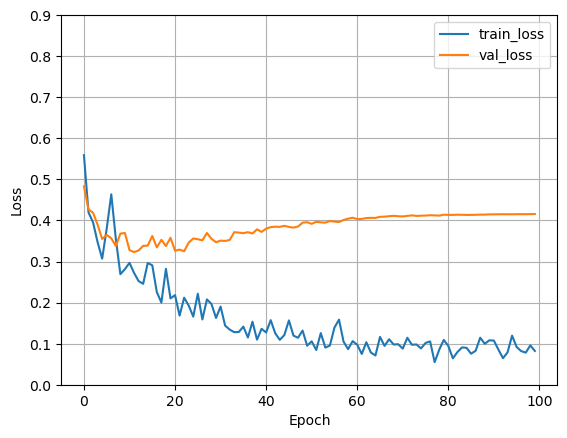

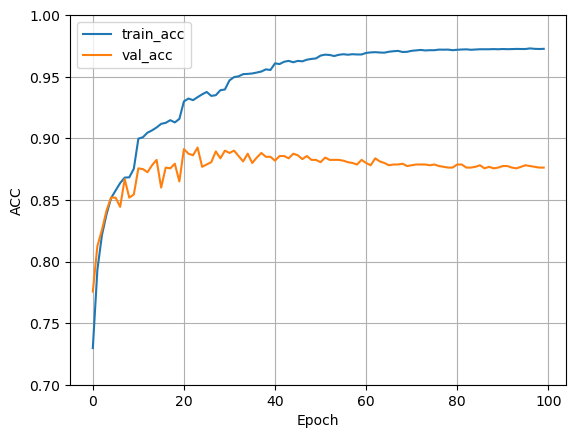

In [10]:
### Plot
import matplotlib.pyplot as plt
import pandas as pd
import os

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
dir_name = 'stepLR'

if not os.path.exists(dir_name):
    os.mkdir(dir_name)
plt.ylim([0.0, 0.9])

plt.savefig(f"{dir_name}/loss.png")

df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.ylim([0.7, 1.0])
plt.savefig(f"{dir_name}/acc.png")

plt.show()

In [7]:
trainer.test(model=lightning_model, datamodule=dm)

/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 125/125 [00:00<00:00, 459.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8802499771118164     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8802499771118164}]

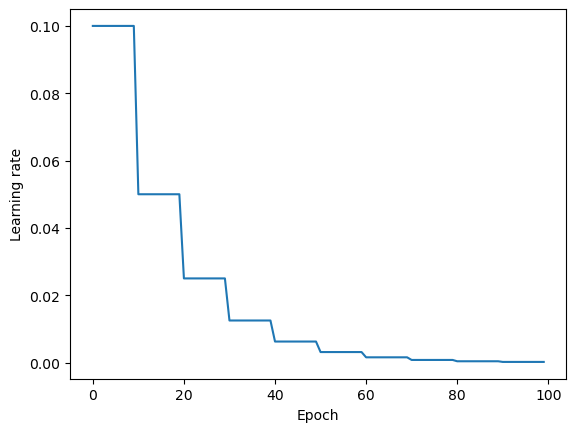

In [8]:
opt = torch.optim.SGD(pytorch_model.parameters(), lr=0.1)
sch = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)


lrs = []
max_epochs = 100

for epoch in range(max_epochs):
    opt.step()
    lrs.append(opt.param_groups[0]["lr"])
    sch.step()

plt.plot(range(max_epochs), lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')

#plt.savefig('steps.pdf')
plt.show()